<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

2023-11-16 19:25:13.142521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# descargaremos un pipeline de pre-procesamiento de SpaCy en español
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 9.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [3]:
# cargar pipeline de pre-procesamiento en español
import spacy
nlp = spacy.load("es_core_news_sm")

In [4]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [5]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola, te saludamos desde Bit en que podemos ayudarte?", "Hola! Bienvenido a Bit! ¿En que podemos servirte hoy?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?"],
              "responses": ["Somos bit! Agencia de marketing digital para servirte", "Somos una agencia de marketing digital con el nombre bit!"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp", "Cual es su contacto?, Como puedo contactarme con ustedes?"],
              "responses": ["Podes contactarnos al siguiente numero 0973 127 251, llamadas y whatsapp o en nuestras redes sociales (Instagram: @bitmkt o Fb: bit marketing digital)", "Contactos al whatsapp 0973 127 251 o en nuestras redes sociales (Instagram: @bitmkt o Fb: bit marketing digital)"]
             },
            {"tag": "envios",
              "patterns": ["¿Realizan envios?", "¿Cómo me llega el paquete?"],
              "responses": ["No realizamos envios, somos una empresa que ofrecer servicios de marketing digital"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?"],
              "responses": ["Entra en contacto con nosotros al 097312725 o en nuestras redes sociales (Instagram: @bitmkt o Fb: bit marketing digital) y te preparamos un presupuesto acorde a tus necesidades :)"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["Recibimos pagos atravez de Giros y transferencias bancarias, porfavor escribi la palabra -Contacto- y escribinos para mas informacion."]
             },
             {"tag": "presupuesto",
              "patterns": [ "presupuesto","pasar presupuesto", "quiero marketing"],
              "responses": ["Para realizar un presupuesto de acuerdo a tus necesidades porvafor contactate con nosotros para marcar un reunion virtual o presencial a nuestro whatsapp o redes sociales"]
             },
            {"tag": "de donde son",
              "patterns": [ "de donde son","son de ciudad de este?", "de que ciudad son?"],
              "responses": ["Actualmente hacemos oficina en Ciudad del este - Paraguay, pero prestamos servicios a todos los paises y personas que necesiten de nuestros servicios digitales :)"]
             },
            {"tag": "sesiones",
              "patterns": [ "fotos","marcar fotos", "marcar sesion de fotos"],
              "responses": ["Para marcar una sesion de fotos porfavor comunicate a nuestro whatsapp o nuestras redes sociales para atenderte mejor y poder darte una cotizacion y fecha acorde a tus necesidades"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta estamos a la ordenes para todos tus proyectos! :)"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego! Te esperamos pronto", "Hablamos luego!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [6]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [7]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['chau', 'ciudad', 'como', 'con', 'contactarme', 'contacto', 'credito', 'cual', 'cuanto', 'cuota', 'de', 'donde', 'el', 'envio', 'este', 'foto', 'gracia', 'gracias', 'hasta', 'holar', 'llegar', 'luego', 'marcar', 'marketing', 'medio', 'mucho', 'nombre', 'numero', 'pago', 'paquete', 'pasar', 'podrar', 'precio', 'presupuesto', 'puedo', 'que', 'querer', 'quien', 'realizar', 'salir', 'ser', 'sesion', 'so', 'su', 'tal', 'tarjeta', 'telefono', 'tu', 'tú', 'valer', 'whatsapp', 'yo']
classes: ['agradecimientos', 'bienvenida', 'contacto', 'de donde son', 'despedida', 'envios', 'nombre', 'pagos', 'precios', 'presupuesto', 'sesiones']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', 'contacto', 'número de contacto', 'número de teléfono', 'número de whatsapp', 'whatsapp', 'Cual es su contacto?, Como puedo contactarme con ustedes?', '¿Realizan envios?', '¿Cómo me llega el paquete?', 'precio', 'Me podrás pasar los precios', '¿Cuánto vale?', '¿Cuánto sale?', '

In [8]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 52


In [9]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 11


In [10]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0,

### 5 - Entrenamiento del modelo

In [11]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (52,) output: 11


In [12]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6784      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 11)                715       
                                                                 
Total params: 15755 (61.54 KB)
Trainable params: 15755 (61.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [13]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 8ms/step - loss: 2.4055 - accuracy: 0.0882
Epoch 2/200
2/2 [==============================] - 0s 4ms/step - loss: 2.4594 - accuracy: 0.0588
Epoch 3/200
2/2 [==============================] - 0s 5ms/step - loss: 2.3664 - accuracy: 0.1765
Epoch 4/200
2/2 [==============================] - 0s 4ms/step - loss: 2.3433 - accuracy: 0.0882
Epoch 5/200
2/2 [==============================] - 0s 4ms/step - loss: 2.3720 - accuracy: 0.0882
Epoch 6/200
2/2 [==============================] - 0s 4ms/step - loss: 2.3732 - accuracy: 0.0588
Epoch 7/200
2/2 [==============================] - 0s 4ms/step - loss: 2.3100 - accuracy: 0.2353
Epoch 8/200
2/2 [==============================] - 0s 4ms/step - loss: 2.3034 - accuracy: 0.1471
Epoch 9/200
2/2 [==============================] - 0s 4ms/step - loss: 2.2651 - accuracy: 0.2941
Epoch 10/200
2/2 [==============================] - 0s 4ms/step - loss: 2.3808 - accuracy: 0.1471
Epoch 11/200
2/2 [===========

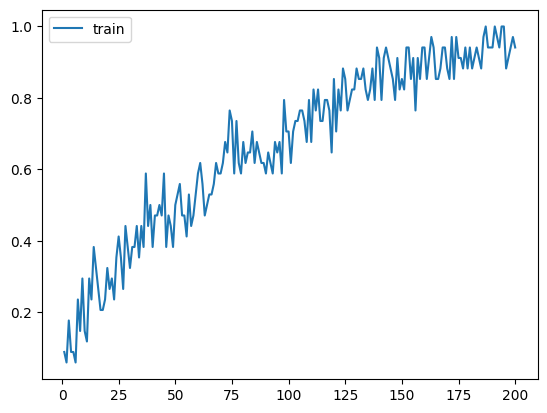

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [15]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# En NLP además de los modelos es necesario proveer: tokenizador y vocabulario.
# La tríada modelo+tokenizador+vocabulario es necesaria para hacer inferencia. 
# Sin una de las tres no se puede hacer inferencia.

# en este caso guardamos:
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

/Users/carlosmontiel/anaconda3/envs/nlp/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 6 - Testing y validación

In [16]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [17]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Q: hola!!
1/1 [==============================] - 0s 99ms/step
BOT: Hola! Bienvenido a Bit! ¿En que podemos servirte hoy?
Q: quiero pedir un presupuesto
1/1 [==============================] - 0s 28ms/step
BOT: Para realizar un presupuesto de acuerdo a tus necesidades porvafor contactate con nosotros para marcar un reunion virtual o presencial a nuestro whatsapp o redes sociales
Q: podrias pasarme tu contacto?
1/1 [==============================] - 0s 24ms/step
BOT: Podes contactarnos al siguiente numero 0973 127 251, llamadas y whatsapp o en nuestras redes sociales (Instagram: @bitmkt o Fb: bit marketing digital)
Q: Genial! y para marcar sesiones de fotos?
1/1 [==============================] - 0s 24ms/step
BOT: Para marcar una sesion de fotos porfavor comunicate a nuestro whatsapp o nuestras redes sociales para atenderte mejor y poder darte una cotizacion y fecha acorde a tus necesidades
Q: perfecto! de donde son?
1/1 [==============================] - 0s 23ms/step
BOT: Actualmente hac

### 7 - Conclusiones
Al modificar el corpus del ejercicio se adapto perfectamente a los nuevos documentos incluso pansandole nuevos promps responde como esperado!